**Table of contents**<a id='toc0_'></a>    
1.1. [Load Data](#toc1_1_)    
1.2. [Data Visualization](#toc1_2_)    
1.3. [Assumptions Check](#toc1_3_)    
1.3.1. [Dependency check](#toc1_3_1_)    
1.3.2. [Normality & Homoscedasticity Assumptions Check](#toc1_3_2_)    
1.4. [Analyse of Variances](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg

## 1.1. <a id='toc1_1_'></a>[Load Data](#toc0_)

In [3]:
df = pd.read_excel("data/data.xlsx")
df.head()

,Date,LC2A,MP2,MP1,MC
0,22/10/2025 18:00,721.0,870.75,845.12,850.2
1,22/10/2025 20:00,650.0,760.20,848.10,889.8
2,22/10/2025 22:30,644.0,638.40,749.00,682.3
3,23/10/2025 01:00,636.0,552.70,741.00,658.2
4,23/10/2025 04:00,649.0,607.42,755.40,670.2


In [4]:
cols = ['Date', 'LC2A', 'MP2', 'MP1', 'MC']

data = df[cols].melt(id_vars='Date', var_name='group', value_name='value',).dropna().sort_values(by='Date')
data.head(6)

,Date,group,value
0,22/10/2025 18:00,LC2A,721.00
69,22/10/2025 18:00,MC,850.20
46,22/10/2025 18:00,MP1,845.12
23,22/10/2025 18:00,MP2,870.75
70,22/10/2025 20:00,MC,889.80
24,22/10/2025 20:00,MP2,760.20


In [5]:
stats_summary = data.groupby('group')['value']

stats_summary: pd.DataFrame = pd.concat(
    [
        stats_summary.describe(include=[np.number]),
        stats_summary.agg(
            [stats.skew, stats.kurtosis]
        ),
    ],
    axis=1,
)

stats_summary.T

group,LC2A,MC,MP1,MP2
count,19.000000,23.000000,23.000000,23.000000
mean,716.947368,711.901304,731.074348,686.379130
std,60.875532,84.157592,60.525671,87.209891
min,636.000000,566.000000,626.000000,535.000000
25%,660.000000,673.350000,683.490000,628.350000
50%,721.000000,700.550000,742.000000,680.000000
75%,772.000000,771.375000,755.200000,740.400000
max,811.000000,889.800000,848.100000,870.750000
skew,0.087651,0.038906,-0.097738,0.171716
kurtosis,-1.388329,-0.329581,-0.377239,-0.632090


## 1.2. <a id='toc1_2_'></a>[Data Visualization](#toc0_)

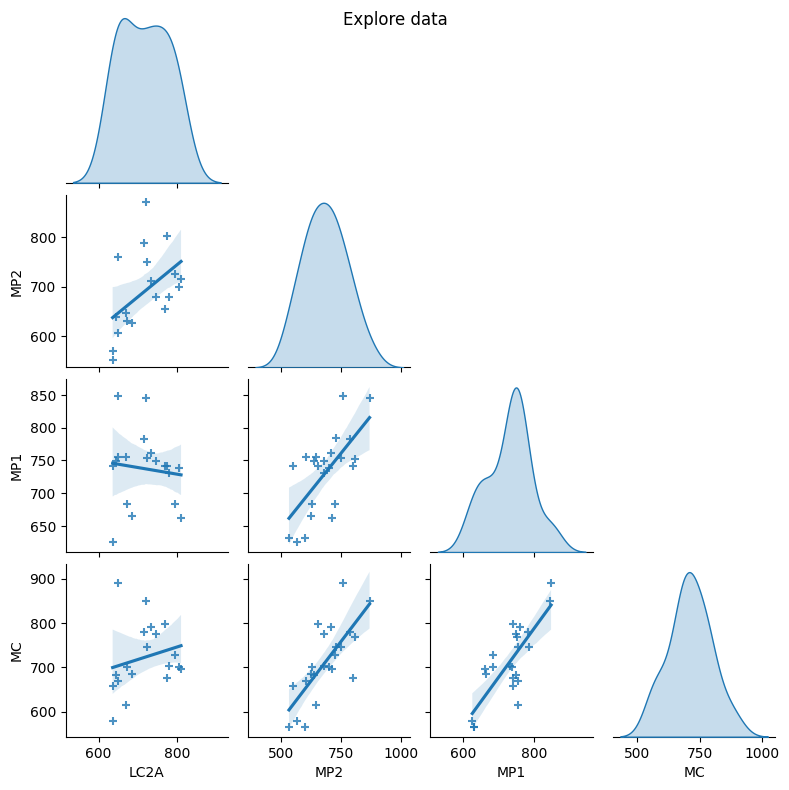

In [42]:

sns.pairplot(df[cols], height=2, kind='reg', diag_kind='kde', markers='+', corner=True)
plt.suptitle("Explore data")
plt.show()

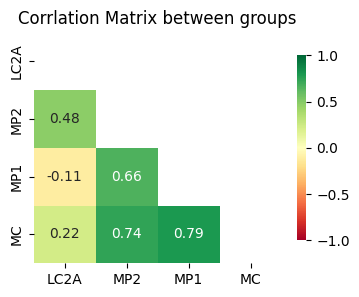

In [43]:
# check dependency between groups
corr_matrix = df.corr(numeric_only=True)
# TODO
upper_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
plt.figure(figsize=[4,3])
sns.heatmap(corr_matrix, 
            mask=upper_mask,
            cbar_kws={'shrink':0.8},
            annot=True, vmax=1, vmin=-1, cmap='RdYlGn')
plt.title("Corrlation Matrix between groups");


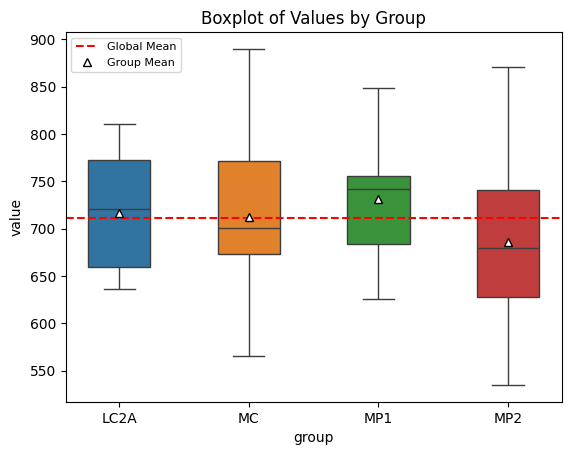

In [44]:
# plt.style.use("seaborn-v0_8-dark")
sns.boxplot(
    data=data,
    x="group",
    y="value",
    hue="group",
    # show means
    showmeans=True,
    meanprops={
        "marker": "^",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "6",
    },
    gap=1.6,
)

# Add a horizontal line at y=0.5
horizontal_line = plt.axhline(y=data.value.mean(), color='r', linestyle='--', label='Global Mean')
# Add mean marker to legend
plt.plot([], [], marker='^', color='w', markeredgecolor='black', markersize=6, linestyle='None', label='Group Mean')

plt.legend(fontsize=8)

plt.grid(False)
plt.title("Boxplot of Values by Group")
plt.show()

## 1.3. <a id='toc1_3_'></a>[Assumptions Check](#toc0_)

### 1.3.1. <a id='toc1_3_1_'></a>[Dependency check](#toc0_)

In [45]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox


def check_dependency_assumption(
    df: pd.DataFrame, dv="value", group="group"
) -> tuple[float, float, bool]:
    """
    Checks for dependency in the data using Durbin-Watson and Ljung-Box tests.
    The Ljung-Box test is performed for lags 1, 2, and 3.

    Args:
        data (dict): A dictionary containing 'group' and 'growth' data.

    Returns:
        tuple[float, float, bool]: A tuple containing:
            - dw_statistic (float): The Durbin-Watson statistic.
                                dw close to 2 suggests no autocorrelation.
                        Values < 2 indicate positive autocorrelation,
                                while values > 2 indicate negative autocorrelation.
            - min_ljung_box_pvalue (float): The minimum p-value from the Ljung-Box test across lags 1-3.
                                p-value < 0.05 suggests significant autocorrelation at that lag.
            - dependency_result (bool): True if dependency is detected, False otherwise.
    """
    # 1. The formula 'growth ~ C(group)' treats 'group' as a categorical variable
    model = ols(f"{dv} ~ C({group})", data=df.dropna()).fit()

    # 2. Calculate the Durbin-Watson statistic from the model residuals
    dw_statistic = durbin_watson(model.resid)

    # 3. Perform the Ljung-Box test on the model residuals for lags 1, 2, and 3
    lags_to_test = [1, 2, 3]
    ljung_box_result = acorr_ljungbox(model.resid, lags=lags_to_test, return_df=True)

    # Get the minimum p-value from the tested lags
    min_ljung_box_pvalue = ljung_box_result["lb_pvalue"].min()

    # 4. Determine the dependency result
    # Check if any of the Ljung-Box p-values are significant
    is_ljung_box_significant = (ljung_box_result["lb_pvalue"] < 0.05).any()

    # Dependency is suspected if DW is far from 2 OR any Ljung-Box p-value is significant
    dependency_result = bool(
        (dw_statistic < 1.5 or dw_statistic > 2.5) or is_ljung_box_significant
    )

    return dw_statistic, min_ljung_box_pvalue, dependency_result


# Get the results
dw_stat, lb_p, dependency = check_dependency_assumption(data)

# Print the results
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
print(f"Minimum Ljung-Box p-value (lags 1-3): {lb_p:.4f}")
print(f"Dependency Suspected: {dependency}")

Durbin-Watson Statistic: 0.7371
Minimum Ljung-Box p-value (lags 1-3): 0.0000
Dependency Suspected: True


### 1.3.2. <a id='toc1_3_2_'></a>[Normality & Homoscedasticity Assumptions Check](#toc0_)

In [46]:
normality_result = pg.normality(data=data, dv='value', group='group', method='shapiro')
is_all_normal = normality_result.all(bool_only=True).iat[0]
normality_result

,W,pval,normal
group,,,
LC2A,0.919723,0.111841,True
MC,0.971725,0.730211,True
MP1,0.921319,0.071101,True
MP2,0.985983,0.979343,True


In [47]:
equal_var_test_result = pg.homoscedasticity(data.dropna(), dv='value', group='group')
is_equal_var = equal_var_test_result.all(bool_only=True).iat[0]
equal_var_test_result


,W,pval,equal_var
levene,1.622377,0.1903,True


## 1.4. <a id='toc1_4_'></a>[Analyse of Variances](#toc0_)

In [48]:
if is_all_normal:
    test_category = 'parametric'
    if is_equal_var:
        method = '1 way anova'
        poste_hoc = 'tukey-hsd'
else:
    test_category = 'parametric'
    if is_equal_var:
        method = 'welch_anova'
        poste_hoc = 'gameshowell'

print(f"ANOVA method: {method},\nPost-hoc test: {poste_hoc}")

ANOVA method: 1 way anova,
Post-hoc test: tukey-hsd


In [49]:
if test_category == 'parametric':
    match(method):
        case '1 way anova':
            test_result = pg.anova(data, dv='value', between='group')
            post_hoc = pg.pairwise_tukey(data, dv='value', between='group')
        case 'welch_anova':
            test_result = pg.welch_anova(data, dv='value', between='group')
            
        case _:
            pass
else:
    match(method):
        case 'kruskal':
            test_result = pg.kruskal(data, dv='value', between='group')
            post_hoc = pg.pairwise_tests(data, dv='value', between='group', parametric=False, padjust='bonferroni')
        case 'mwu':
            pass
        case _:
            pass


In [50]:
pval= test_result['p-unc'].values[0]
print(f"{method:<20} p-value: {pval:.4g}")
if pval <= 0.05:
	print("Significant differences detected between groups (H0 rejected).\nProceeding with post-hoc test.")
else:
	print("No significant differences detected between groups.")
	display(post_hoc)

1 way anova          p-value: 0.2421
No significant differences detected between groups.


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,LC2A,MC,716.947368,711.901304,5.046064,23.200357,0.217499,0.996339,0.066378
1,LC2A,MP1,716.947368,731.074348,-14.126979,23.200357,-0.608912,0.928983,-0.228406
2,LC2A,MP2,716.947368,686.379130,30.568238,23.200357,1.317576,0.554438,0.392098
3,MC,MP1,711.901304,731.074348,-19.173043,22.067941,-0.868819,0.820902,-0.257085
4,MC,MP2,711.901304,686.379130,25.522174,22.067941,1.156527,0.655720,0.292712
5,MP1,MP2,731.074348,686.379130,44.695217,22.067941,2.025346,0.186961,0.585228
